**Importing Data And Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


2024-07-29 21:41:37.963357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 21:41:37.963527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 21:41:38.122269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = pd.read_csv("/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv")

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     6252 non-null   object
 1   category  6252 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 97.8+ KB


In [3]:
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


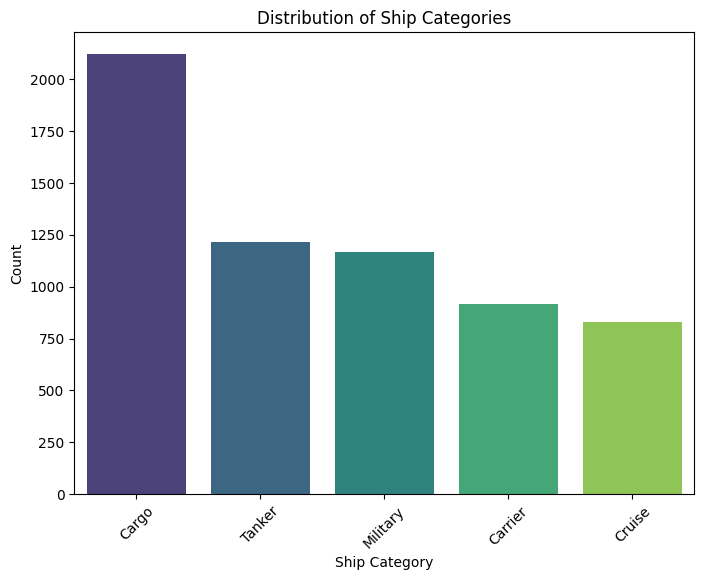

In [4]:
ship_categories = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}
category_counts = train["category"].map(ship_categories).value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xlabel('Ship Category')
plt.ylabel('Count')
plt.title('Distribution of Ship Categories')
plt.xticks(rotation=45)
plt.show()


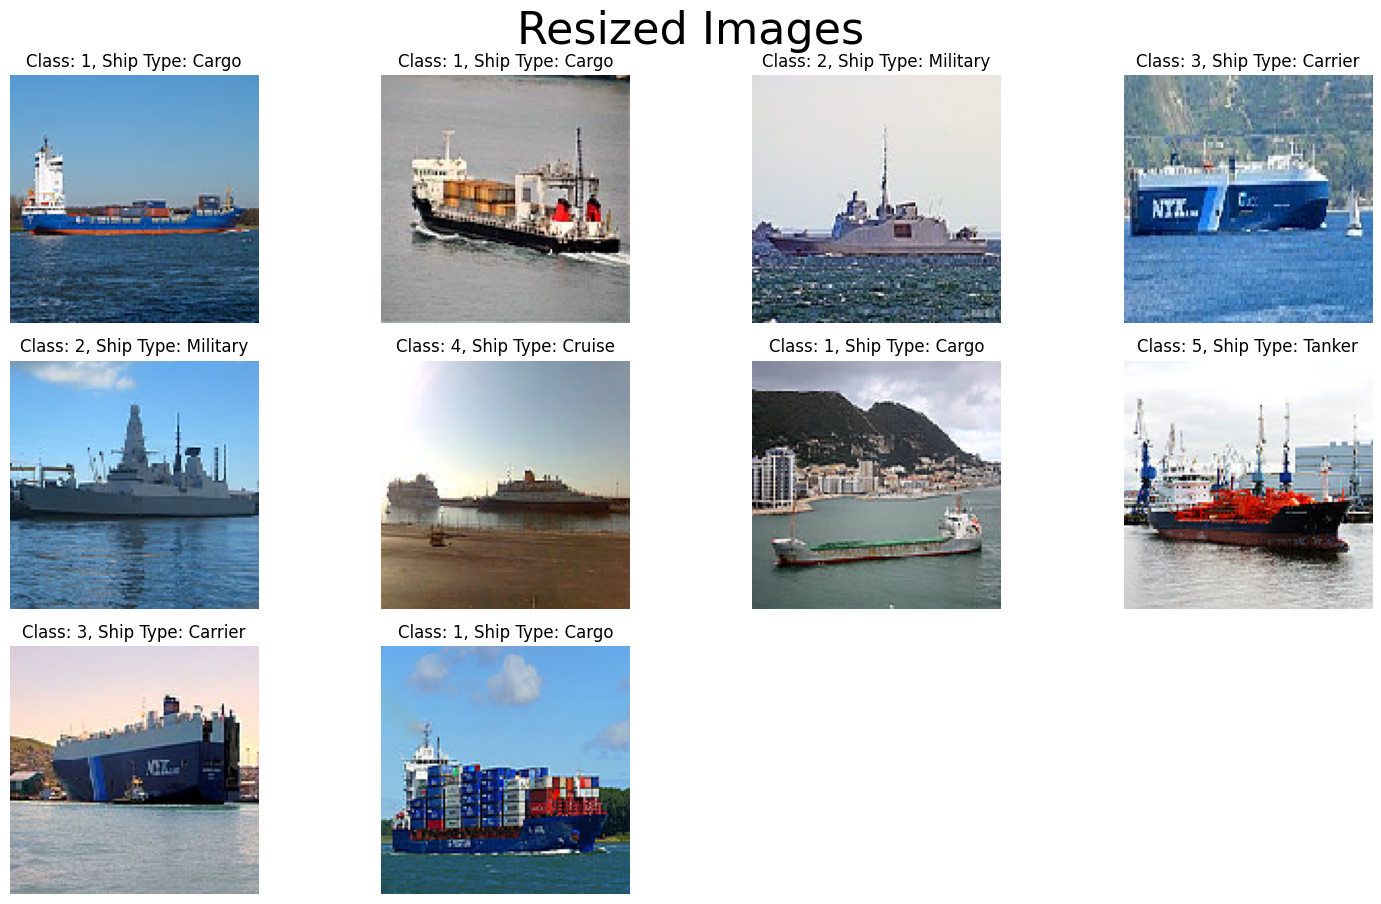

In [5]:
path = "/kaggle/input/game-of-deep-learning-ship-datasets/train/images"
target_shape = (128, 128, 3)
refactor_size = 128

def load_and_preprocess_image(image_path, target_shape):
    img = plt.imread(image_path)
    img = cv2.resize(img, (target_shape[1], target_shape[0]))  # Resize the image
    return img

resized_image_list = []
all_paths = []

for i in range(len(train)):
    image_path = os.path.join(path, train["image"][i])
    img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)
    resized_image_list.append(imgarr)
    all_paths.append(image_path)

resized_image_list = np.asarray(resized_image_list)

nrow = 5
ncol = 4
fig1 = plt.figure(figsize=(15, 15))
fig1.suptitle('Resized Images', size=32)
for i in range(10):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(resized_image_list[i])
    plt.title('Class: {x}, Ship Type: {y}'.format(x=train["category"][i], y=ship_categories[train["category"][i]]))
    plt.axis('Off')
    plt.grid(False)
plt.tight_layout()
plt.show()

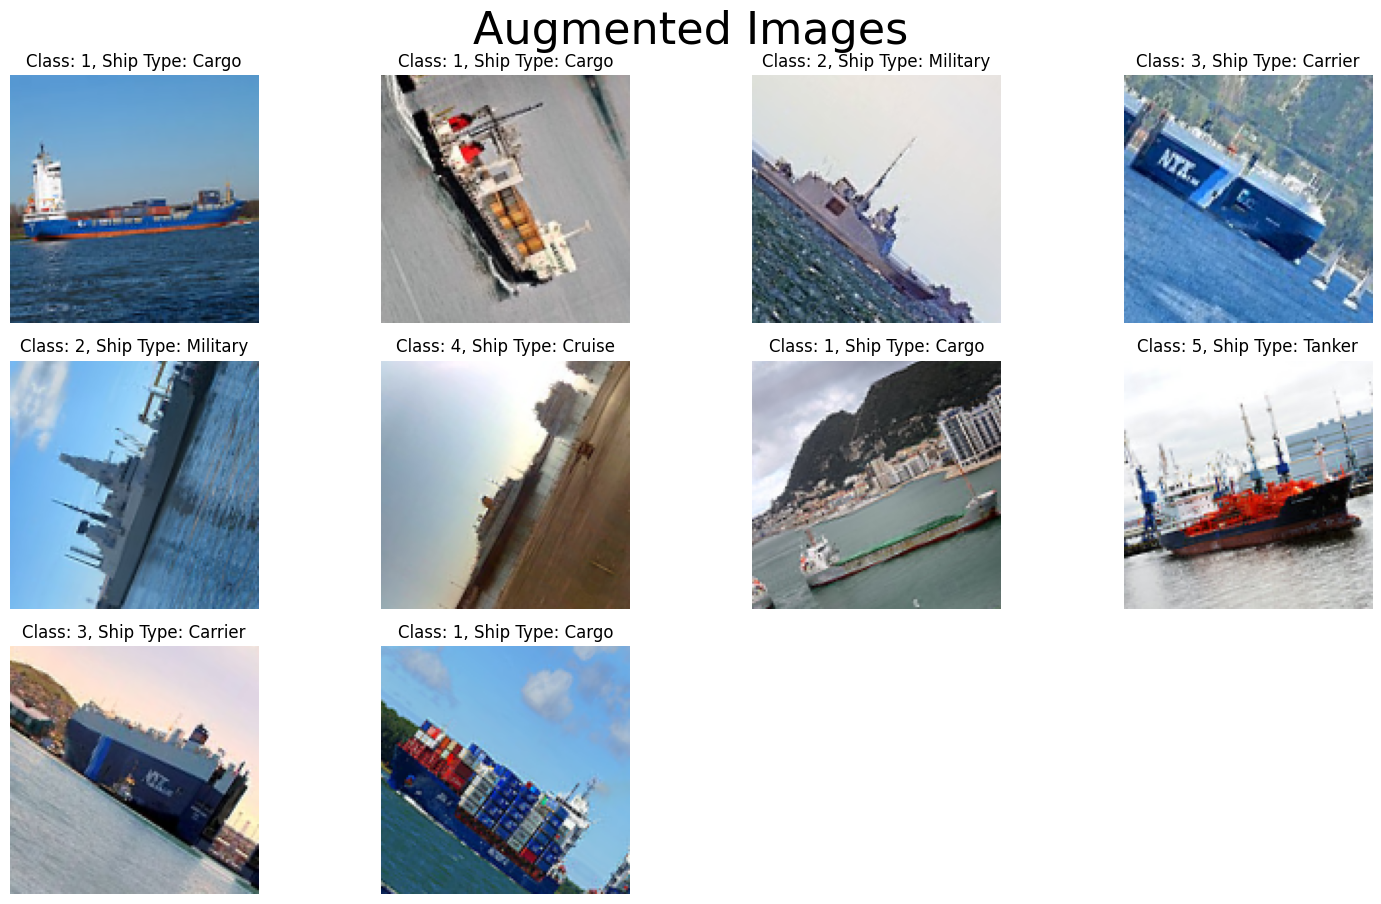

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

augmented_images = data_augmentation(resized_image_list)

fig2 = plt.figure(figsize=(15, 15))
fig2.suptitle('Augmented Images', size=32)
for i in range(10):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(augmented_images[i])
    plt.title('Class: {x}, Ship Type: {y}'.format(x=train["category"][i], y=ship_categories[train["category"][i]]))
    plt.axis('Off')
    plt.grid(False)
plt.tight_layout()
plt.show()


In [7]:
class_values = train["category"] - 1
class_values.value_counts()

ship_categories = {0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tanker'}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(resized_image_list, class_values, random_state=30)
print(X_train.shape, y_train.shape)


(4689, 128, 128, 3) (4689,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

enhanced_model = Sequential([
    Input(shape=(128, 128, 3)),
    
    data_augmentation,
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(5, activation='softmax')
])


enhanced_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

enhanced_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,242,053 (20.00 MB)

 Trainable params: 5,241,093 (19.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model_enhanced.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

# Train the model
history_enhanced = enhanced_model.fit(X_train, y_train, 
                                      validation_data=(X_test, y_test), 
                                      epochs=50, 
                                      callbacks=[checkpoint])


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.2585 - loss: 4.2507
Epoch 1: val_accuracy improved from -inf to 0.23544, saving model to best_model_enhanced.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 923ms/step - accuracy: 0.2586 - loss: 4.2416 - val_accuracy: 0.2354 - val_loss: 1.6786
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.3131 - loss: 1.7024
Epoch 2: val_accuracy improved from 0.23544 to 0.24952, saving model to best_model_enhanced.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 925ms/step - accuracy: 0.3132 - loss: 1.7021 - val_accuracy: 0.2495 - val_loss: 1.6278
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.3773 - loss: 1.5144
Epoch 3: val_accuracy did not improve from 0.24952
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 923ms/step - accuracy: 0.3773 - loss: 1.5142 - val_accuracy: 0.2163 - val_loss: 2.7583
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.4265 - loss: 1.4005
Epoch 4: val_accuracy improved from 0.249

In [11]:
from sklearn.metrics import classification_report

best_model = load_model('best_model_enhanced.keras')

test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

print("Shape of y_test:", y_test.shape)

if y_test.ndim > 1:
    y_true_classes = np.argmax(y_test, axis=1)
else:
    y_true_classes = y_test 

classification_metrics = classification_report(y_true_classes, y_pred_classes)
print("\nClassification Report:")
print(classification_metrics)


NameError: name 'load_model' is not defined